In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tqdm import tqdm  # For progress tracking
import pandas as pd
import requests
import os

import time
from tqdm import tqdm
from collections import defaultdict, Counter

# plots
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def extract_families(uniprot_ids):
  """
    Retrieve and extract protein family annotations from the UniProt database for a list of UniProt IDs.

    This function queries the UniProt REST API for each provided UniProt ID, extracts associated
    Pfam and InterPro family identifiers, and counts the frequency of these families across all proteins.
    For each protein, the most frequent Pfam family (if any) is recorded.

    Args:
        uniprot_ids (list of str): A list of UniProt protein accession IDs to query.

    Returns:
        pd.DataFrame: A DataFrame with columns ["Protein_ID", "Pfam_Families"], mapping each protein ID
                      to its most frequently occurring Pfam family (if found).

    Notes:
        - The function introduces a small delay (0.1s) between requests to avoid API rate limits.
        - Requires 'requests', 'pandas', 'tqdm' libraries.
  """
  # UniProt API endpoint
  base_url = "https://rest.uniprot.org/uniprotkb/"

  # Dictionaries to store family counts
  pfam_counts = Counter()
  interpro_counts = Counter()
  protein_to_pfam = defaultdict(list)

  # Query UniProt API
  for index, protein_id in tqdm(enumerate(uniprot_ids), desc='Extracting Families...', total=len(uniprot_ids)):
      response = requests.get(f"{base_url}{protein_id}.json")

      if response.status_code == 200:
          data = response.json()

          # Extract Pfam & InterPro families
          pfam_list = []
          interpro_list = []

          for entry in data.get("uniProtKBCrossReferences", []):
              db, family_id = entry["database"], entry["id"]
              if db == "Pfam":
                  pfam_list.append(family_id)
              elif db == "InterPro":
                  interpro_list.append(family_id)

          # Choose the most frequent family per protein (if any exist)
          if pfam_list:
              most_common_pfam = Counter(pfam_list).most_common(1)[0][0]
              pfam_counts[most_common_pfam] += 1
              protein_to_pfam[protein_id] = most_common_pfam

          if interpro_list:
              most_common_interpro = Counter(interpro_list).most_common(1)[0][0]
              interpro_counts[most_common_interpro] += 1

      else:
          print(f"Failed to retrieve data for {protein_id}")

      # Print progress every 100 proteins
      if (index + 1) % 100 == 0:
          print(f"Processed {index + 1} proteins...")


      # Delay to avoid API rate limits
      time.sleep(0.1)

  # Sorting families by frequency (descending)
  sorted_pfam = sorted(pfam_counts.items(), key=lambda x: x[1], reverse=True)
  sorted_interpro = sorted(interpro_counts.items(), key=lambda x: x[1], reverse=True)

  df_pfam = pd.DataFrame(protein_to_pfam.items(), columns=["Protein_ID", "Pfam_Families"])
  return df_pfam


In [4]:
# loading Plinder Data (train+valid+test split)

plinder = pd.read_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plinder_pocket_data_only1_ligands.csv')
plinder

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles
0,1grx,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O
1,3grj,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1
2,2grt,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
3,2grt,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
4,6grq,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...
...,...,...,...,...,...,...
128842,5ib9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128843,5ib9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128844,4xpp,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O
128845,3ug6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...


In [5]:
print(f"Plinder Total Dataset Size: {len(plinder)} \nValid Dataset Size: {len(plinder[plinder['split']=='val'])} \nTrain Dataset Size: {len(plinder[plinder['split']=='train'])} \nTrain + Valid Dataset Size: {len(plinder[plinder['split']=='train']) + len(plinder[plinder['split']=='val'])} \nTest Dataset Size {len(plinder[plinder['split']=='test'])}")

Plinder Total Dataset Size: 128847 
Valid Dataset Size: 7460 
Train Dataset Size: 116644 
Train + Valid Dataset Size: 124104 
Test Dataset Size 4743


### Preprocessing
- Drop duplicate pdb ids
- Convert pdb_ids to uniprot ids

In [6]:
plinder = plinder.drop_duplicates(subset='pdb_id')
plinder['pdb_id'] = plinder['pdb_id'].str.upper()
plinder

/tmp/ipython-input-6-3549886971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plinder['pdb_id'] = plinder['pdb_id'].str.upper()


,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
4,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...
6,6GRI,6gri__1__1.C_2.C__1.I_1.J__1.I,1,train,6gri__1__1.C_2.C__1.I_1.J,CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)COP...
...,...,...,...,...,...,...
128839,7RGF,7rgf__1__1.A__1.F__1.F,1,test,7rgf__1__1.A__1.F,OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O
128841,3RGX,3rgx__1__1.A__1.G__1.G,1,test,3rgx__1__1.A__1.G,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O
128842,5IB9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128844,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O


In [7]:
pdb_uniprot = pd.read_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/pdb_to_uniprot.csv')
pdb_uniprot

,pdb_id,uniprot_id
0,103M,P02185
1,107M,P02185
2,108M,P02185
3,11AS,P00963
4,11BG,P00669
...,...,...
78606,9ICS,P06746
78607,9ICT,P06746
78608,9NSE,P29473
78609,9RSA,P61823


In [8]:
pdb_uniprot_unique = pdb_uniprot.drop_duplicates(subset='pdb_id')

In [9]:
# geting uniprot ids to plinder proteins

plinder_uniprot = pd.merge(plinder, pdb_uniprot_unique, on='pdb_id', how='left')
plinder_uniprot

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,P68688
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1,P00811
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390
3,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q8K4V6
4,6GRI,6gri__1__1.C_2.C__1.I_1.J__1.I,1,train,6gri__1__1.C_2.C__1.I_1.J,CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)COP...,P23184
...,...,...,...,...,...,...,...
30844,7RGF,7rgf__1__1.A__1.F__1.F,1,test,7rgf__1__1.A__1.F,OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O,Q91XX0
30845,3RGX,3rgx__1__1.A__1.G__1.G,1,test,3rgx__1__1.A__1.G,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,O22476
30846,5IB9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759
30847,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O,A0A0F7R6D6


In [10]:
plinder_uniprot.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plinder_uniprot_uniques.csv')

### extracting families (run in a cluster)

In [11]:
# This was executed in a cluster due to colab computational limitations
#plinder_families = extract_families(plinder_uniprot['uniprot_id'])

Extracting Families...:   0%|          | 30/30849 [00:18<4:46:40,  1.79it/s]

Failed to retrieve data for nan


Extracting Families...:   0%|          | 100/30849 [01:02<4:56:59,  1.73it/s]

Processed 100 proteins...


Extracting Families...:   1%|          | 167/30849 [01:44<4:56:13,  1.73it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 200/30849 [02:05<5:27:25,  1.56it/s]

Processed 200 proteins...


Extracting Families...:   1%|          | 228/30849 [02:21<4:47:28,  1.78it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 235/30849 [02:25<4:50:25,  1.76it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 267/30849 [02:45<4:33:21,  1.86it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 269/30849 [02:46<4:43:25,  1.80it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 286/30849 [02:56<4:48:46,  1.76it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 300/30849 [03:05<5:10:02,  1.64it/s]

Processed 300 proteins...


Extracting Families...:   1%|          | 302/30849 [03:06<4:53:37,  1.73it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 313/30849 [03:13<5:06:34,  1.66it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|          | 369/30849 [03:46<4:42:54,  1.80it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|▏         | 400/30849 [04:05<4:58:21,  1.70it/s]

Processed 400 proteins...


Extracting Families...:   1%|▏         | 433/30849 [04:25<4:31:53,  1.86it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|▏         | 440/30849 [04:29<4:36:59,  1.83it/s]

Failed to retrieve data for nan


Extracting Families...:   1%|▏         | 446/30849 [04:32<5:04:10,  1.67it/s]

Failed to retrieve data for nan


Extracting Families...:   2%|▏         | 500/30849 [05:06<5:28:41,  1.54it/s]

Processed 500 proteins...


Extracting Families...:   2%|▏         | 600/30849 [06:06<5:01:16,  1.67it/s]

Processed 600 proteins...


Extracting Families...:   2%|▏         | 632/30849 [06:24<4:29:59,  1.87it/s]

Failed to retrieve data for nan


Extracting Families...:   2%|▏         | 645/30849 [06:32<4:57:11,  1.69it/s]

Failed to retrieve data for nan


Extracting Families...:   2%|▏         | 654/30849 [06:37<4:45:38,  1.76it/s]

Failed to retrieve data for nan


Extracting Families...:   2%|▏         | 682/30849 [06:54<4:59:30,  1.68it/s]

Failed to retrieve data for nan


Extracting Families...:   2%|▏         | 700/30849 [07:05<5:22:14,  1.56it/s]

Processed 700 proteins...


Extracting Families...:   3%|▎         | 800/30849 [08:07<4:49:37,  1.73it/s]

Processed 800 proteins...


Extracting Families...:   3%|▎         | 842/30849 [08:32<4:44:37,  1.76it/s]

Failed to retrieve data for nan


Extracting Families...:   3%|▎         | 900/30849 [09:06<5:16:42,  1.58it/s]

Processed 900 proteins...


Extracting Families...:   3%|▎         | 1000/30849 [10:05<4:39:59,  1.78it/s]

Processed 1000 proteins...


Extracting Families...:   3%|▎         | 1016/30849 [10:14<4:23:22,  1.89it/s]

Failed to retrieve data for nan


Extracting Families...:   4%|▎         | 1100/30849 [11:02<4:34:25,  1.81it/s]

Processed 1100 proteins...


Extracting Families...:   4%|▍         | 1180/30849 [11:51<5:01:04,  1.64it/s]

Failed to retrieve data for nan


Extracting Families...:   4%|▍         | 1182/30849 [11:52<4:37:55,  1.78it/s]

Failed to retrieve data for nan


Extracting Families...:   4%|▍         | 1182/30849 [11:52<4:58:13,  1.66it/s]


KeyboardInterrupt: 

## Create in-domain and out-domain inference sets

Read plinder_pfam, add family name

In [12]:
plinder_pfam_unique = pd.read_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plinder_pfams.csv', index_col=0)

In [13]:
plinder_pfam_unique

,Protein_ID,Pfam_Families
0,P68688,PF00462
1,P00811,PF00144
2,P00390,PF07992
3,Q8K4V6,PF00047
4,P0DTD1,PF13087
...,...,...
6674,O92367,PF03996
6675,A2WPN7,PF01419
6676,Q8YSD9,PF09150
6677,Q91XX0,PF00028


In [14]:
# Pfams with family name
pfam_df = pd.read_csv("/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/Pfam-A.clans.tsv.gz", sep='\t', names=['pfam_id', 'pfam_cl_id', 'pfam_name', 'clan_id', 'clan_name'])
pfam_df

,pfam_id,pfam_cl_id,pfam_name,clan_id,clan_name
0,PF00001,CL0192,GPCR_A,7tm_1,7 transmembrane receptor (rhodopsin family)
1,PF00002,CL0192,GPCR_A,7tm_2,7 transmembrane receptor (Secretin family)
2,PF00003,CL0192,GPCR_A,7tm_3,7 transmembrane sweet-taste receptor of 3 GCPR
3,PF00004,CL0023,P-loop_NTPase,AAA,ATPase family associated with various cellular...
4,PF00005,CL0023,P-loop_NTPase,ABC_tran,ABC transporter
...,...,...,...,...,...
24419,PF25508,NaN,NaN,TRPM2,TRPM2-like domain
24420,PF25509,CL0036,TIM_barrel,DUF7916,Domain of unknown function (DUF7916)
24421,PF25510,CL0072,Ubiquitin,Ubiquitin_DCDC1,"Doublecortin domain-containing protein 1-like,..."
24422,PF25511,CL0159,E-set,Ig_CNNM4_N,"Metal transporter CNNM4-like, immunoglobulin-l..."


In [15]:
pfam_df_merged = plinder_pfam_unique.merge(pfam_df[['pfam_id', 'pfam_name', 'clan_name']], left_on='Pfam_Families', right_on='pfam_id', how='left')
pfam_df_merged

,Protein_ID,Pfam_Families,pfam_id,pfam_name,clan_name
0,P68688,PF00462,PF00462,Thioredoxin,Glutaredoxin
1,P00811,PF00144,PF00144,Beta-lactamase,Beta-lactamase
2,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
3,Q8K4V6,PF00047,PF00047,E-set,Immunoglobulin domain
4,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
...,...,...,...,...,...
6674,O92367,PF03996,PF03996,SGNH_hydrolase,Hemagglutinin esterase
6675,A2WPN7,PF01419,PF01419,Man_lectin,Jacalin-like lectin domain
6676,Q8YSD9,PF09150,PF09150,NaN,"Orange carotenoid protein, N-terminal"
6677,Q91XX0,PF00028,PF00028,E-set,Cadherin domain


In [16]:
plinder_uniprot_pfam = pd.merge(pdb_uniprot, pfam_df_merged, left_on='uniprot_id', right_on='Protein_ID')
plinder_uniprot_pfam = plinder_uniprot_pfam.drop('Protein_ID', axis=1)
plinder_uniprot_pfam

,pdb_id,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
0,103M,P02185,PF00042,PF00042,Globin,Globin
1,107M,P02185,PF00042,PF00042,Globin,Globin
2,108M,P02185,PF00042,PF00042,Globin,Globin
3,11BG,P00669,PF00074,PF00074,NaN,Pancreatic ribonuclease
4,1A00,P68871,PF00042,PF00042,Globin,Globin
...,...,...,...,...,...,...
42920,9ICS,P06746,PF14792,PF14792,NTP_transf,DNA polymerase beta palm
42921,9ICT,P06746,PF14792,PF14792,NTP_transf,DNA polymerase beta palm
42922,9NSE,P29473,PF00667,PF00667,Hybrid,FAD binding domain
42923,9RSA,P61823,PF00074,PF00074,NaN,Pancreatic ribonuclease


In [17]:
# loading Plinder Data (train+valid+test split)

plinder = pd.read_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plinder_pocket_data_only1_ligands.csv')
plinder

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles
0,1grx,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O
1,3grj,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1
2,2grt,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
3,2grt,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
4,6grq,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...
...,...,...,...,...,...,...
128842,5ib9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128843,5ib9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128844,4xpp,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O
128845,3ug6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...


In [18]:
plinder['pdb_id'] = plinder['pdb_id'].str.upper()
plinder

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
3,2GRT,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...
4,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...
...,...,...,...,...,...,...
128842,5IB9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128843,5IB9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...
128844,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O
128845,3UG6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...


In [19]:
metadata_pfam = pd.merge(plinder, plinder_uniprot_pfam, on='pdb_id', how='left')
metadata_pfam

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,P68688,PF00462,PF00462,Thioredoxin,Glutaredoxin
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1,P00811,PF00144,PF00144,Beta-lactamase,Beta-lactamase
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
3,2GRT,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
4,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q8K4V6,PF00047,PF00047,E-set,Immunoglobulin domain
...,...,...,...,...,...,...,...,...,...,...,...
148307,5IB9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759,PF02225,PF02225,Leu-IlvD,PA domain
148308,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O,A0A0F7R6D6,PF17137,PF17137,NaN,Domain of unknown function (DUF5110)
148309,3UG6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,Q58542,PF02374,PF02374,P-loop_NTPase,Anion-transporting ATPase
148310,2Y8L,2y8l__1__1.C__1.E__1.E,1,test,2y8l__1__1.C__1.E,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,O43741,PF16561,PF16561,GHD,Glycogen recognition site of AMP-activated pro...


In [20]:
metadata_pfam = metadata_pfam.drop_duplicates(subset='ligand_id')
metadata_pfam

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,P68688,PF00462,PF00462,Thioredoxin,Glutaredoxin
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1,P00811,PF00144,PF00144,Beta-lactamase,Beta-lactamase
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
3,2GRT,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
4,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q8K4V6,PF00047,PF00047,E-set,Immunoglobulin domain
...,...,...,...,...,...,...,...,...,...,...,...
148306,5IB9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759,PF02225,PF02225,Leu-IlvD,PA domain
148307,5IB9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759,PF02225,PF02225,Leu-IlvD,PA domain
148308,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O,A0A0F7R6D6,PF17137,PF17137,NaN,Domain of unknown function (DUF5110)
148309,3UG6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,Q58542,PF02374,PF02374,P-loop_NTPase,Anion-transporting ATPase


In [21]:
print('Interactions with pfamily in train split', len(metadata_pfam[metadata_pfam['split'] == 'train']))
print('Interactions with pfamily in val split', len(metadata_pfam[metadata_pfam['split'] == 'val']))
print('Interactions with pfamily in train+val split', len(metadata_pfam[metadata_pfam['split'] == 'val'] + metadata_pfam[metadata_pfam['split'] == 'train']))
print('Interactions with pfamily in test split', len(metadata_pfam[metadata_pfam['split'] == 'test']))

Interactions with pfamily in train split 116644
Interactions with pfamily in val split 1302
Interactions with pfamily in train+val split 117946
Interactions with pfamily in test split 4369


In [22]:
print('In all Plinder there are', len(metadata_pfam['Pfam_Families'].value_counts()), 'unique families')
print('In all Train+Valid split there are', len(metadata_pfam[metadata_pfam['split'].isin(['train', 'val'])]['Pfam_Families'].value_counts()), 'unique families')
print('In all Test split there are', len(metadata_pfam[metadata_pfam['split']=='test']['Pfam_Families'].value_counts()), 'unique families')

In all Plinder there are 2121 unique families
In all Train+Valid split there are 1685 unique families
In all Test split there are 733 unique families


/tmp/ipython-input-23-3731549250.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


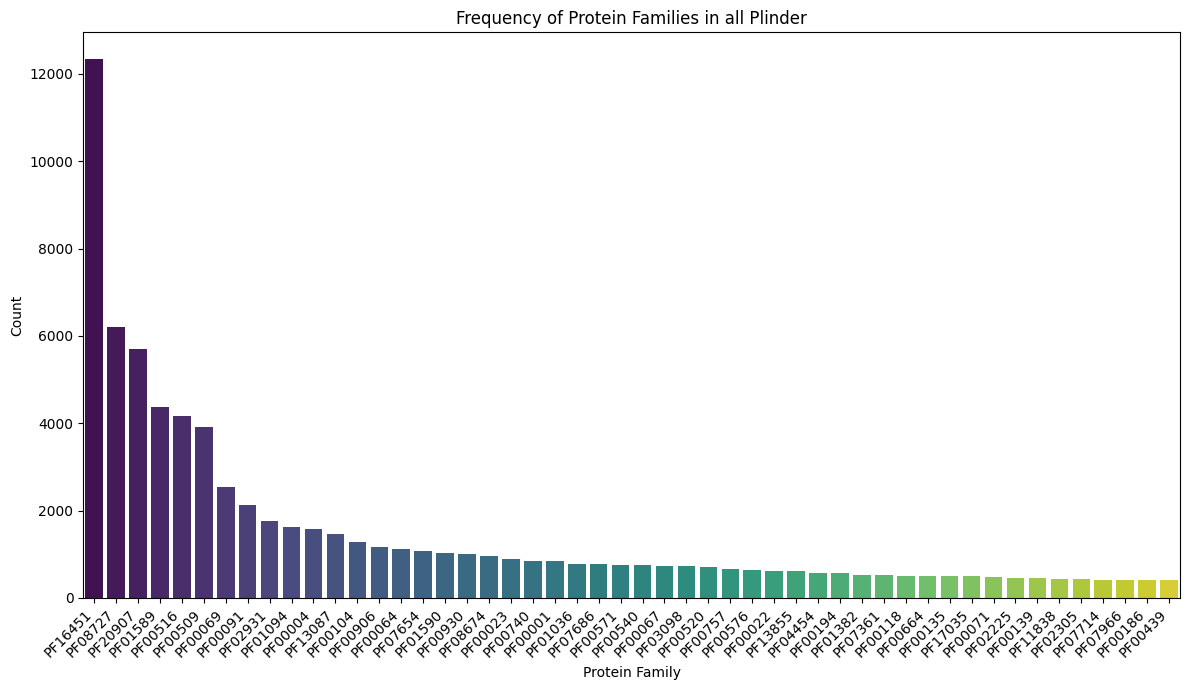

In [23]:
top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = metadata_pfam['Pfam_Families'].value_counts().head(top_n)


# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in all Plinder")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-25-3619704632.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")


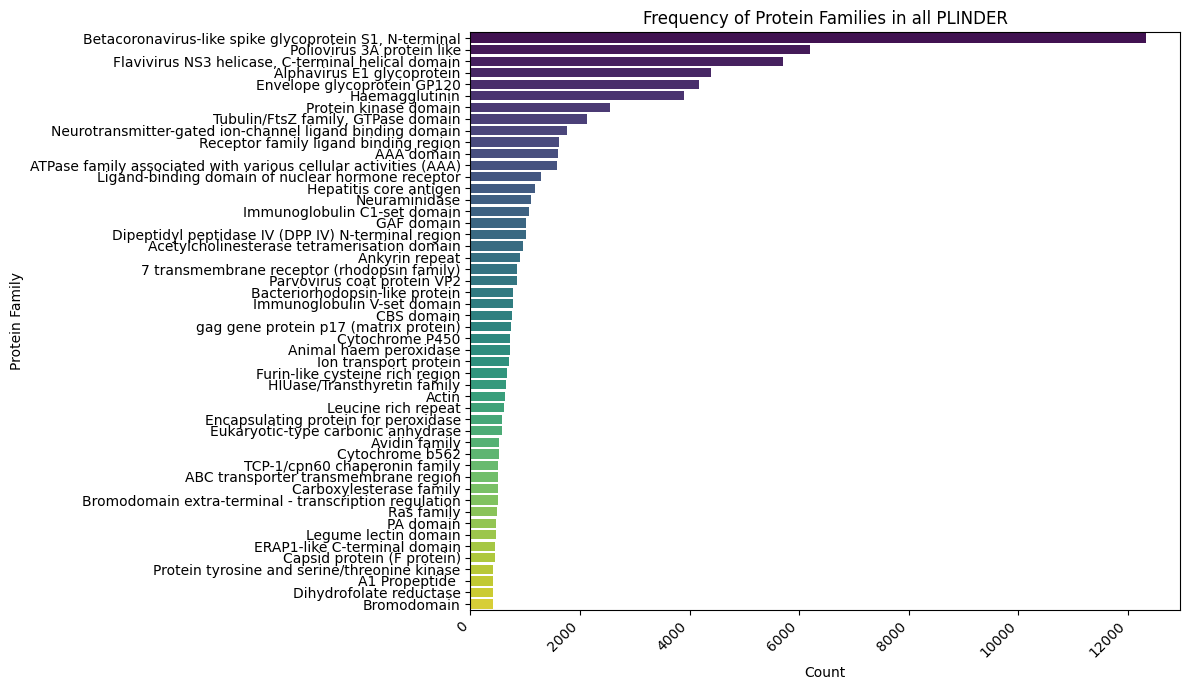

In [25]:
top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = metadata_pfam['clan_name'].value_counts().head(top_n)
output_dir = '/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plots'

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")
plt.ylabel("Protein Family")
plt.xlabel("Count")
plt.title("Frequency of Protein Families in all PLINDER")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"PLINDER_families_freq.png"), dpi=300,  bbox_inches='tight')
plt.show()

/tmp/ipython-input-26-2929181385.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")


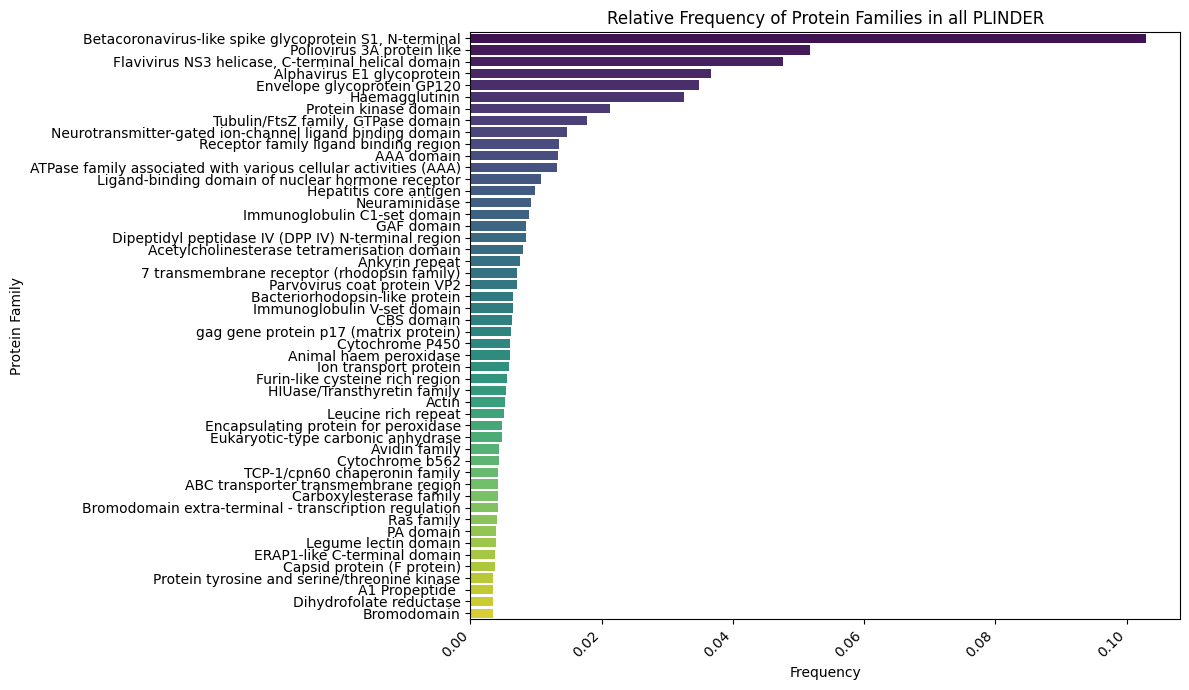

In [26]:
top_n = 50  # top 50 most frequent

# Normalize to frequencies
pfamily_counts = (
    metadata_pfam['clan_name']
    .value_counts(normalize=True)  # Normalize to get relative frequencies
    .head(top_n)            # Convert to percentage
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")
plt.ylabel("Protein Family")
plt.xlabel("Frequency")
plt.title("Relative Frequency of Protein Families in all PLINDER")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plots/PLINDER_families_freq.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-27-2710252692.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


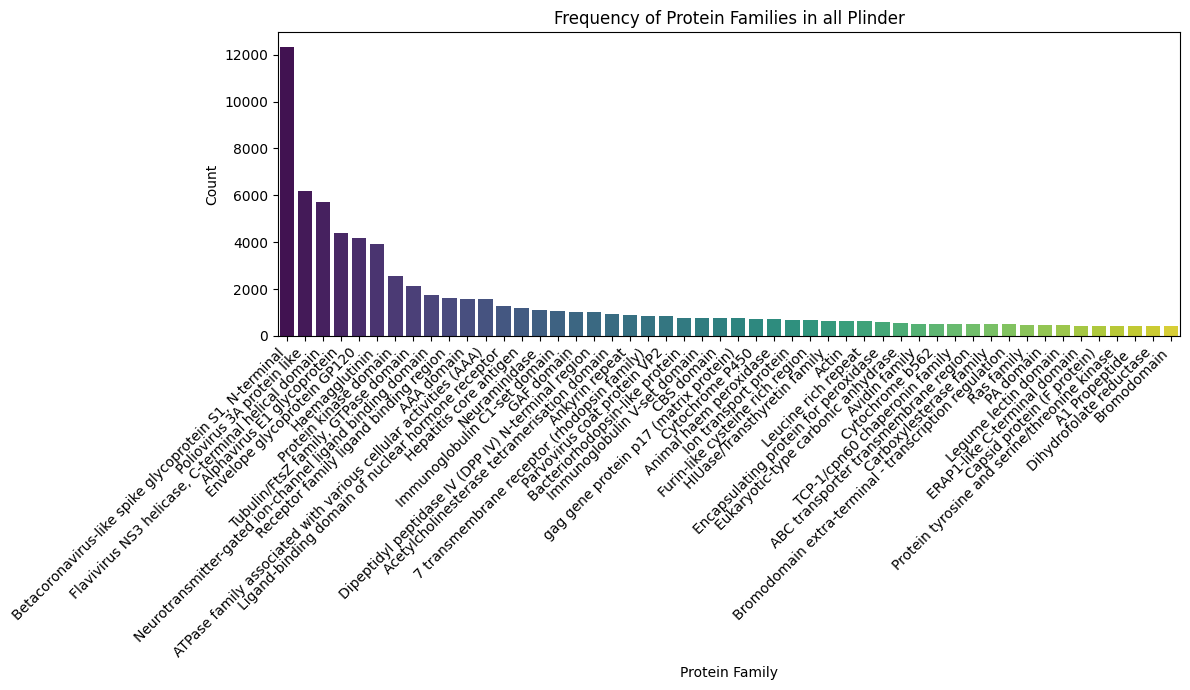

In [27]:
top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = metadata_pfam['clan_name'].value_counts().head(top_n)


# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in all Plinder")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-28-3269451668.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


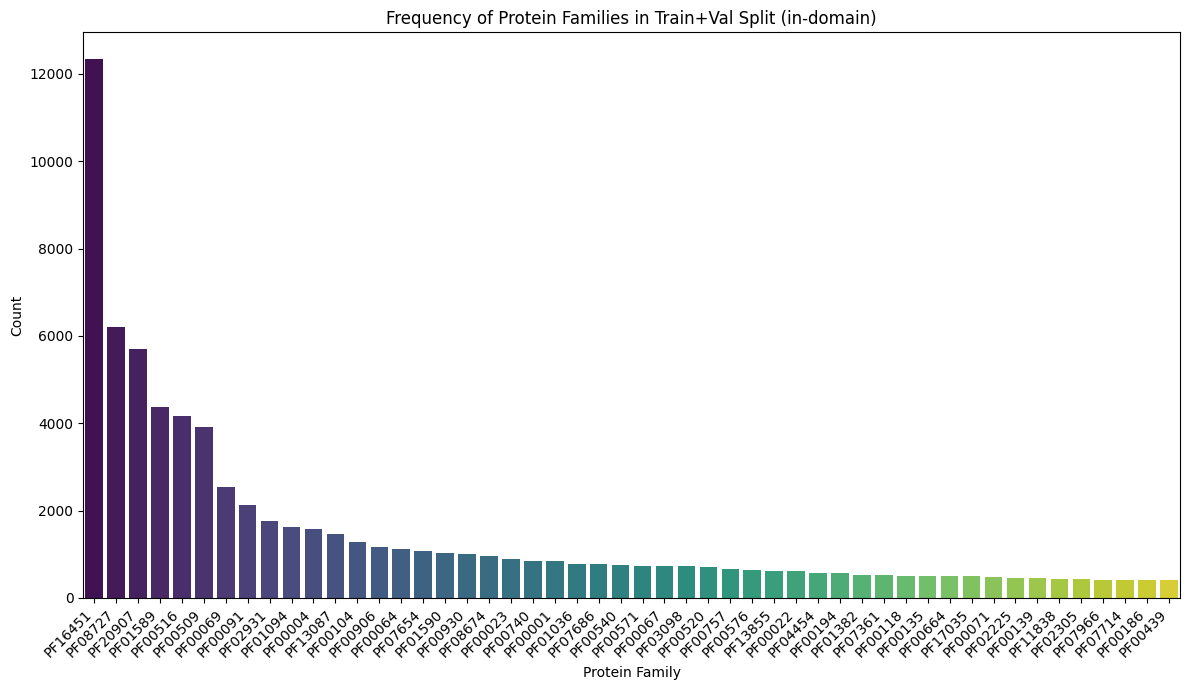

In [28]:
# Filter for train or val
filtered_df = metadata_pfam[metadata_pfam['split'].isin(['train', 'val'])]

top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = filtered_df['Pfam_Families'].value_counts().head(top_n)


# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in Train+Val Split (in-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-29-2327660126.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


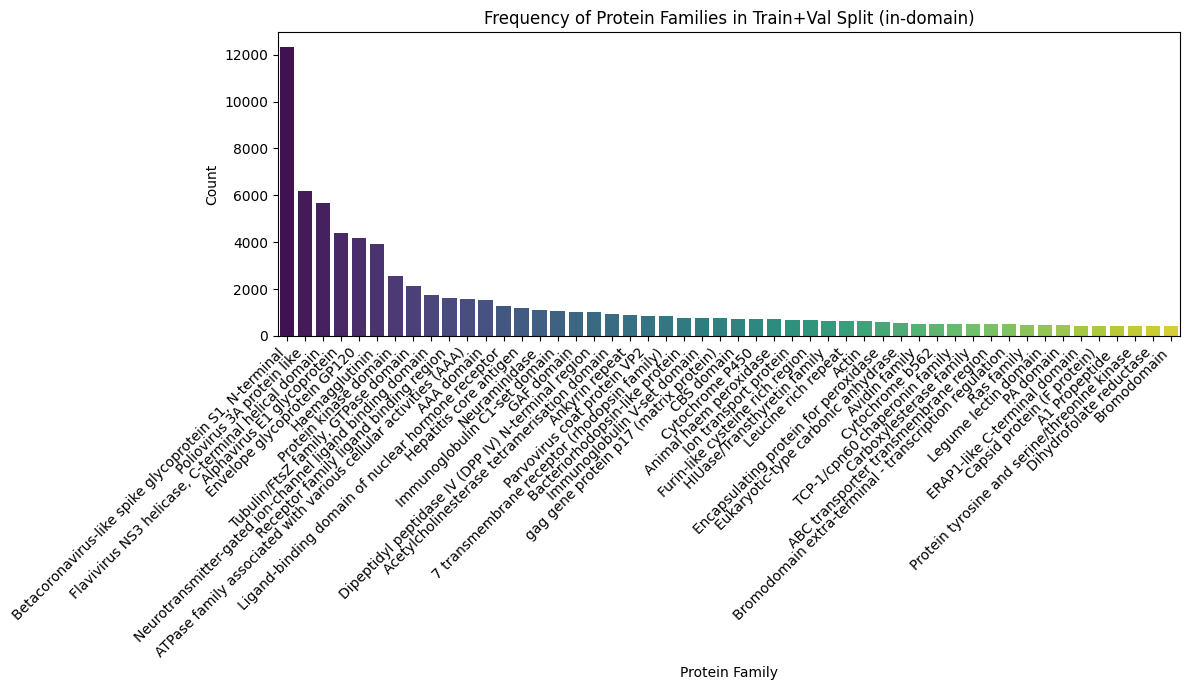

In [29]:
# Filter for train or val
filtered_df = metadata_pfam[metadata_pfam['split'].isin(['train', 'val'])]

top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = filtered_df['clan_name'].value_counts().head(top_n)


# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in Train+Val Split (in-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-548465736.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")


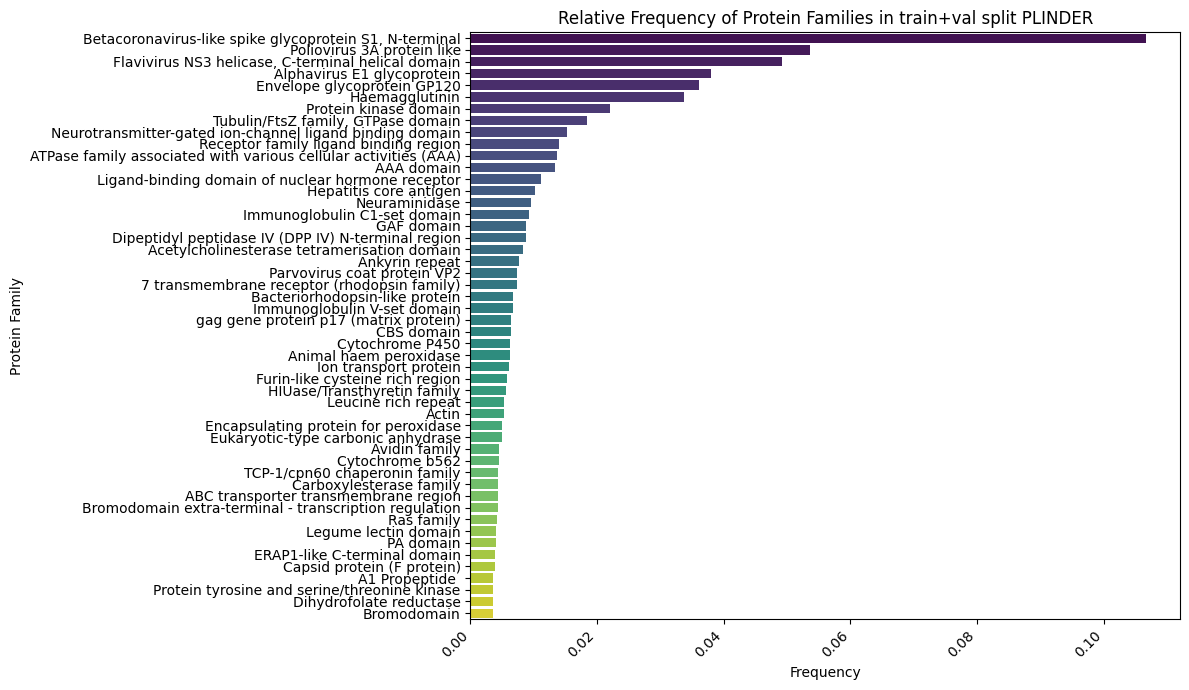

In [30]:
top_n = 50  # top 50 most frequent

# Normalize to frequencies
pfamily_counts = (
    filtered_df['clan_name']
    .value_counts(normalize=True)  # Normalize to get relative frequencies
    .head(top_n)            # Convert to percentage
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")
plt.ylabel("Protein Family")
plt.xlabel("Frequency")
plt.title("Relative Frequency of Protein Families in train+val split PLINDER")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plots/PLINDER_traian_families_freq.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-31-379284944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


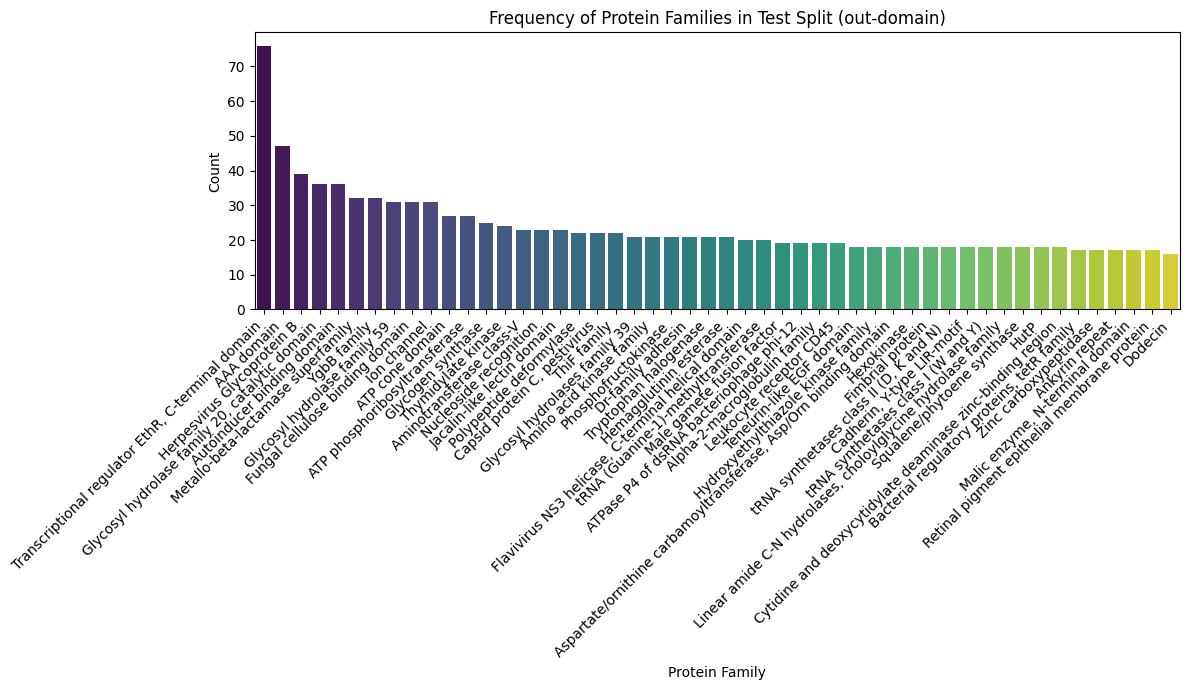

In [31]:
top_n = 50 # top 20 most frequent
# Count frequencies
pfamily_counts = metadata_pfam[metadata_pfam['split'] == 'test']['clan_name'].value_counts().head(top_n)


# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in Test Split (out-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-32-1508417778.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")


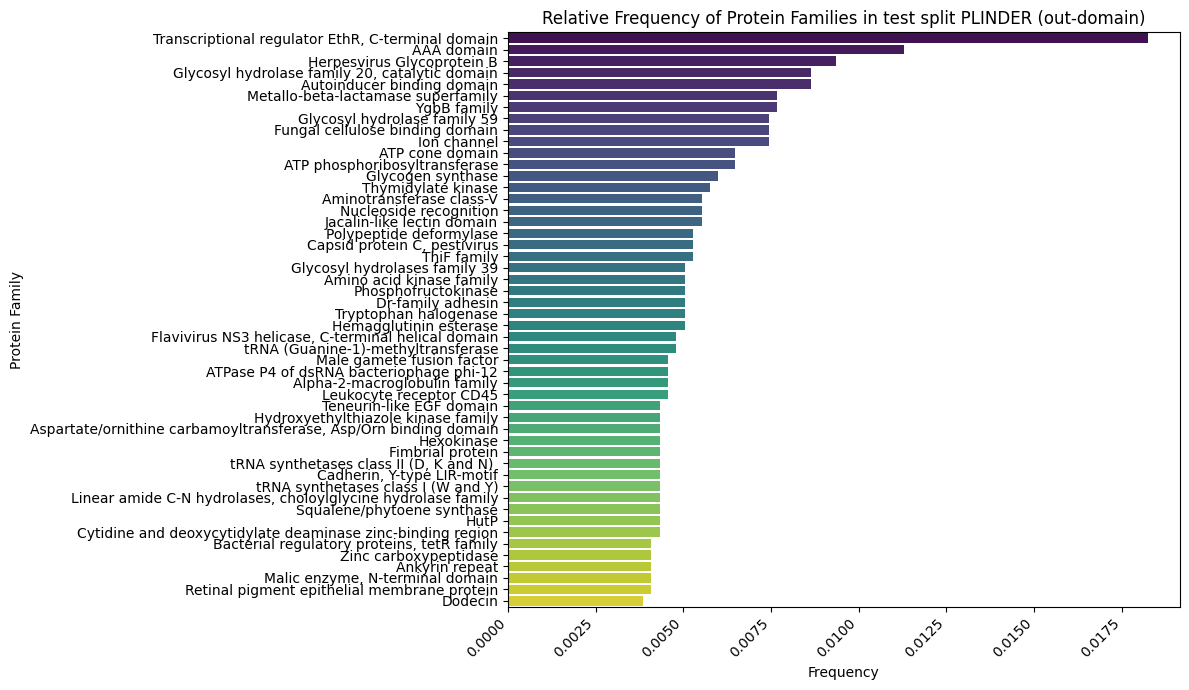

In [32]:
top_n = 50  # top 50 most frequent
filtered_df = metadata_pfam[metadata_pfam['split'] == 'test']

# Normalize to frequencies
pfamily_counts = (
    filtered_df['clan_name']
    .value_counts(normalize=True)  # Normalize to get relative frequencies
    .head(top_n)            # Convert to percentage
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")
plt.ylabel("Protein Family")
plt.xlabel("Frequency")
plt.title("Relative Frequency of Protein Families in test split PLINDER (out-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plots/PLINDER_test_families_freq.png", dpi=300, bbox_inches='tight')
plt.show()

## Create In-domain subsets

In [33]:
train_df = metadata_pfam[metadata_pfam['split'].isin(['train', 'val'])]

In [34]:
# obtain 50 most common
top_50 = 50
top_50_families = train_df['clan_name'].value_counts().head(top_50)

filtered_subset = train_df[train_df['clan_name'].isin(top_50_families.index)]
filtered_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
8,7GRE,7gre__1__1.A__1.C__1.C,1,train,7gre__1__1.A__1.C,FC(F)(F)C1=NNC(C2=CC=NC=C2)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
9,7GRX,7grx__1__1.B__1.N_1.O__1.N,1,train,7grx__1__1.B__1.N_1.O,O=C1CCC(=O)N1C1=CC=C(F)C=C1F,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
10,5GRB,5grb__1__1.A__1.G__1.G,1,train,5grb__1__1.A__1.G,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
11,5GRB,5grb__1__1.C__1.K__1.K,1,train,5grb__1__1.C__1.K,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
12,5GRB,5grb__1__1.E__1.O__1.O,1,train,5grb__1__1.E__1.O,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
...,...,...,...,...,...,...,...,...,...,...,...
143589,7DNZ,7dnz__1__1.A_1.B__1.C_1.H_1.I__1.I,1,val,7dnz__1__1.A_1.B__1.C_1.H_1.I,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143590,7DNZ,7dnz__1__1.A__1.F__1.F,1,val,7dnz__1__1.A__1.F,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143591,7DNZ,7dnz__1__1.B__1.L__1.L,1,val,7dnz__1__1.B__1.L,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143592,3LP1,3lp1__2__1.A_2.A__1.C_1.D_1.E__2.C,1,val,3lp1__2__1.A_2.A__1.C_1.D_1.E,O=C1C(C2CCCC2)=C(O)C2=CC=CN=C2N1O,P04585,PF00540,PF00540,Matrix,gag gene protein p17 (matrix protein)


/tmp/ipython-input-35-1322343792.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


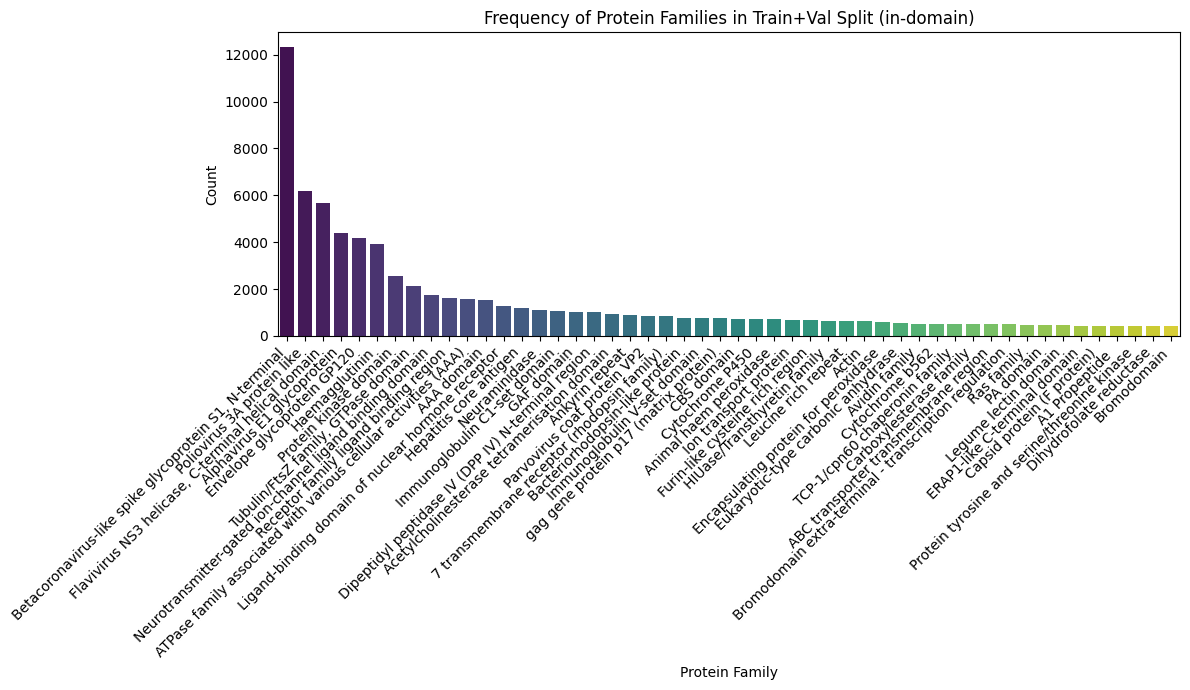

In [35]:
pfamily_counts = filtered_subset['clan_name'].value_counts() # there are already only top 50 families in the df

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in Train+Val Split (in-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# I have been able to replicate the plot so, filtered_subset has the correct top 50 families.

In [36]:
filtered_subset.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/In-domain_top50_allpdbs.csv')
filtered_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
8,7GRE,7gre__1__1.A__1.C__1.C,1,train,7gre__1__1.A__1.C,FC(F)(F)C1=NNC(C2=CC=NC=C2)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
9,7GRX,7grx__1__1.B__1.N_1.O__1.N,1,train,7grx__1__1.B__1.N_1.O,O=C1CCC(=O)N1C1=CC=C(F)C=C1F,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
10,5GRB,5grb__1__1.A__1.G__1.G,1,train,5grb__1__1.A__1.G,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
11,5GRB,5grb__1__1.C__1.K__1.K,1,train,5grb__1__1.C__1.K,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
12,5GRB,5grb__1__1.E__1.O__1.O,1,train,5grb__1__1.E__1.O,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,B9VUU3,PF08727,PF08727,NaN,Poliovirus 3A protein like
...,...,...,...,...,...,...,...,...,...,...,...
143589,7DNZ,7dnz__1__1.A_1.B__1.C_1.H_1.I__1.I,1,val,7dnz__1__1.A_1.B__1.C_1.H_1.I,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143590,7DNZ,7dnz__1__1.A__1.F__1.F,1,val,7dnz__1__1.A__1.F,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143591,7DNZ,7dnz__1__1.B__1.L__1.L,1,val,7dnz__1__1.B__1.L,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143592,3LP1,3lp1__2__1.A_2.A__1.C_1.D_1.E__2.C,1,val,3lp1__2__1.A_2.A__1.C_1.D_1.E,O=C1C(C2CCCC2)=C(O)C2=CC=CN=C2N1O,P04585,PF00540,PF00540,Matrix,gag gene protein p17 (matrix protein)


In [37]:
# Sample randomly 1 proteins per pfamily
balanced_subset_top50 = filtered_subset.groupby('clan_name').sample(n=1, random_state=42)

# Now balanced_subset is balanced across pfamilies
balanced_subset_top50.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/In-domain_top50.csv')
balanced_subset_top50

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
94692,1F88,1f88__3__1.B__1.R__3.R,1,train,1f88__3__1.B__1.R,CC(C=CC=C(C)C=CC1=C(C)CCCC1(C)C)=CC=O,P02699,PF00001,PF00001,GPCR_A,7 transmembrane receptor (rhodopsin family)
63793,1LYB,1lyb__1__2.E__2.J__1.J,1,train,1lyb__1__2.E__2.J,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,P07339,PF07966,PF07966,NaN,A1 Propeptide
59586,8CYZ,8cyz__1__1.A__1.E__1.E,1,train,8cyz__1__1.A__1.E,CSC1=CC=C(N(CC2=CC(Cl)=CS2)C(=O)CC2=CN=CC3=CC=...,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
108485,7ZEC,7zec__1__1.B__1.D_1.E__1.E,1,train,7zec__1__1.B__1.D_1.E,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@@](=O)(O)...,P23886,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
36839,5OG1,5og1__1__1.C_1.D__1.J__1.J,1,train,5og1__1__1.C_1.D__1.J,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)(O)OP(=...,P0ABH9,PF00004,PF00004,P-loop_NTPase,ATPase family associated with various cellular...
39749,1XLU,1xlu__2__1.A__1.D__2.D,1,train,1xlu__2__1.A__1.D,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,P06276,PF08674,PF08674,NaN,Acetylcholinesterase tetramerisation domain
79384,8D15,8d15__1__1.B__1.J_1.K__1.J,1,train,8d15__1__1.B__1.J_1.K,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,P68139,PF00022,PF00022,Actin_ATPase,Actin
58121,6NK6,6nk6__1__51.A__51.Q__1.Q,1,train,6nk6__1__51.A__51.Q,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,Q5XXP3,PF01589,PF01589,Viral_gly_cn_dm,Alphavirus E1 glycoprotein
140535,3PGH,3pgh__1__1.A__1.F__1.F,1,train,3pgh__1__1.A__1.F,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,Q05769,PF03098,PF03098,Peroxidase,Animal haem peroxidase
117313,5IRX,5irx__1__1.D__1.Q__1.Q,1,train,5irx__1__1.D__1.Q,CCCCCC(=O)O[C@@H](COC(=O)CCCC)COP(=O)(O)OCC[N+...,O35433,PF00023,PF00023,Ank,Ankyrin repeat


### Cleaning top5 viruses

In [38]:
# all plinder

# disregard the first 5 protein families which correspond to family of viruses proteins
top_n = 5

# Get top N frequent clan_names
top_pfamilies = metadata_pfam['clan_name'].value_counts().head(top_n).index

# Filter out rows with those clan_names
filtered_subset = metadata_pfam[~metadata_pfam['clan_name'].isin(top_pfamilies)]
filtered_subset

filtered_subset.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/plinder_no_virus.csv')

In [39]:
# disregard the first 5 protein families which correspond to family of viruses proteins
top_n = 5

# Get top N frequent clan_names
top_pfamilies = train_df['clan_name'].value_counts().head(top_n).index

# Filter out rows with those clan_names
filtered_subset = train_df[~train_df['clan_name'].isin(top_pfamilies)]
filtered_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
0,1GRX,1grx__1__1.A__1.B__1.B,1,train,1grx__1__1.A__1.B,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,P68688,PF00462,PF00462,Thioredoxin,Glutaredoxin
1,3GRJ,3grj__1__1.A__1.H__1.H,1,train,3grj__1__1.A__1.H,O=C(O)C1=CNC(C2=CC=CC=C2)=N1,P00811,PF00144,PF00144,Beta-lactamase,Beta-lactamase
2,2GRT,2grt__1__1.A_2.A__1.C__1.C,1,train,2grt__1__1.A_2.A__1.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
3,2GRT,2grt__1__1.A_2.A__2.C__1.C,1,train,2grt__1__1.A_2.A__2.C,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,P00390,PF07992,PF07992,NADP_Rossmann,Pyridine nucleotide-disulphide oxidoreductase
4,6GRQ,6grq__1__1.A__1.B__1.B,1,train,6grq__1__1.A__1.B,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q8K4V6,PF00047,PF00047,E-set,Immunoglobulin domain
...,...,...,...,...,...,...,...,...,...,...,...
143865,3EJA,3eja__1__1.A__1.E__1.E,1,val,3eja__1__1.A__1.E,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,D0VWZ9,PF03443,PF03443,E-set,Auxiliary Activity family 9 (formerly GH61)
143866,7KW2,7kw2__1__1.A__1.C__1.C,1,val,7kw2__1__1.A__1.C,CC(C)(COP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS,Q47NR9,PF00501,PF00501,ANL,AMP-binding enzyme
143867,3IB9,3ib9__1__2.A__2.C__1.C,1,val,3ib9__1__2.A__2.C,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,Q9X4K7,PF01039,PF01039,ClpP_crotonase,Carboxyl transferase domain
143868,3IB9,3ib9__2__1.A__1.C__2.C,1,val,3ib9__2__1.A__1.C,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,Q9X4K7,PF01039,PF01039,ClpP_crotonase,Carboxyl transferase domain


In [40]:
# obtain 50 most common
top_50 = 50
top_50_families = filtered_subset['clan_name'].value_counts().head(top_50)

filtered_subset = filtered_subset[filtered_subset['clan_name'].isin(top_50_families.index)]
filtered_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
8,7GRE,7gre__1__1.A__1.C__1.C,1,train,7gre__1__1.A__1.C,FC(F)(F)C1=NNC(C2=CC=NC=C2)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
9,7GRX,7grx__1__1.B__1.N_1.O__1.N,1,train,7grx__1__1.B__1.N_1.O,O=C1CCC(=O)N1C1=CC=C(F)C=C1F,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
20,7GRN,7grn__1__1.B__1.J__1.J,1,train,7grn__1__1.B__1.J,FC(F)(F)C1=CC=C2NC([C@H]3CCNC3)=NC2=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
21,7GRT,7grt__1__1.A__1.C_1.E_1.I__1.C,1,train,7grt__1__1.A__1.C_1.E_1.I,O=C(NCC1=CC=C2OCCC2=C1)C1=CC=CC=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
28,7GRY,7gry__1__1.B__1.M_1.N__1.N,1,train,7gry__1__1.B__1.M_1.N,O=C1CCC(=O)N1C1=CC(Cl)=CC(Cl)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
...,...,...,...,...,...,...,...,...,...,...,...
143589,7DNZ,7dnz__1__1.A_1.B__1.C_1.H_1.I__1.I,1,val,7dnz__1__1.A_1.B__1.C_1.H_1.I,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143590,7DNZ,7dnz__1__1.A__1.F__1.F,1,val,7dnz__1__1.A__1.F,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143591,7DNZ,7dnz__1__1.B__1.L__1.L,1,val,7dnz__1__1.B__1.L,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143592,3LP1,3lp1__2__1.A_2.A__1.C_1.D_1.E__2.C,1,val,3lp1__2__1.A_2.A__1.C_1.D_1.E,O=C1C(C2CCCC2)=C(O)C2=CC=CN=C2N1O,P04585,PF00540,PF00540,Matrix,gag gene protein p17 (matrix protein)


/tmp/ipython-input-41-3098503413.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


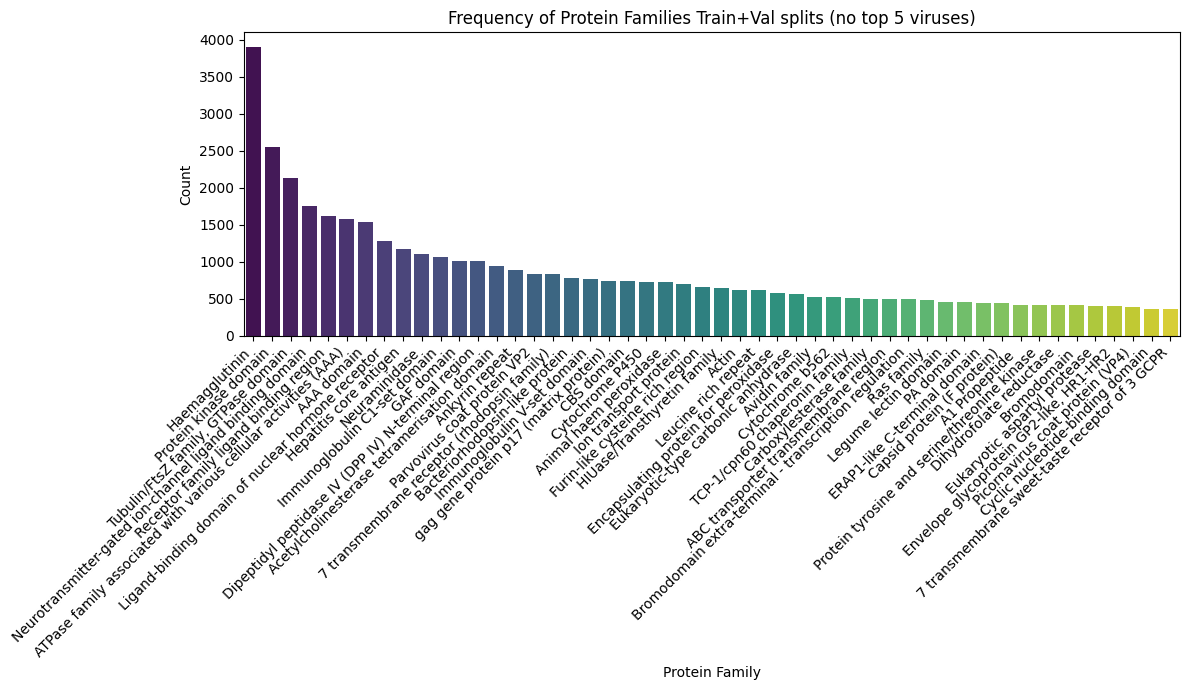

In [41]:
# Count frequencies
pfamily_counts = filtered_subset['clan_name'].value_counts() # there are already only top 50 families in the df

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families Train+Val splits (no top 5 viruses)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# the top 5 viruses are no longer in the plot, we have the correct subset

/tmp/ipython-input-42-779190836.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")


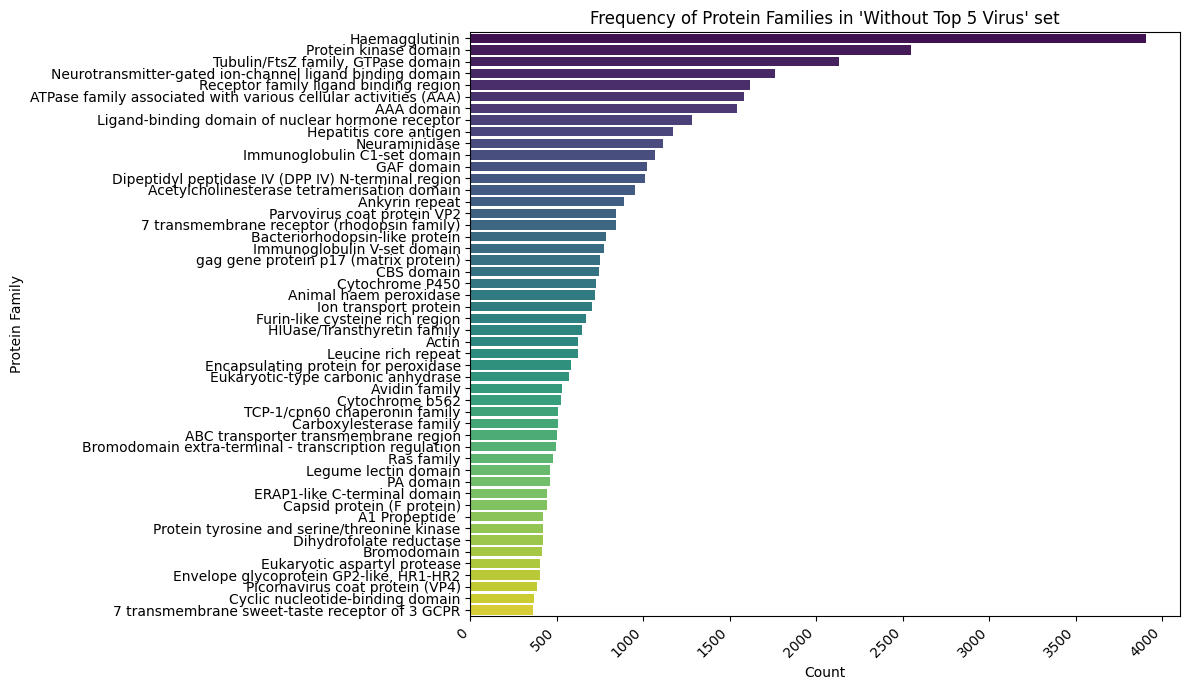

In [42]:
# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=pfamily_counts.index, x=pfamily_counts.values, palette="viridis")
plt.ylabel("Protein Family")
plt.xlabel("Count")
plt.title("Frequency of Protein Families in 'Without Top 5 Virus' set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"novirus_families_freq.png"), dpi=300,  bbox_inches='tight')
plt.show()

In [ ]:
filtered_subset.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/In-domain_top50_no_virus_allpdbs.csv')
filtered_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
8,7GRE,7gre__1__1.A__1.C__1.C,1,train,7gre__1__1.A__1.C,FC(F)(F)C1=NNC(C2=CC=NC=C2)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
9,7GRX,7grx__1__1.B__1.N_1.O__1.N,1,train,7grx__1__1.B__1.N_1.O,O=C1CCC(=O)N1C1=CC=C(F)C=C1F,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
20,7GRN,7grn__1__1.B__1.J__1.J,1,train,7grn__1__1.B__1.J,FC(F)(F)C1=CC=C2NC([C@H]3CCNC3)=NC2=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
21,7GRT,7grt__1__1.A__1.C_1.E_1.I__1.C,1,train,7grt__1__1.A__1.C_1.E_1.I,O=C(NCC1=CC=C2OCCC2=C1)C1=CC=CC=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
28,7GRY,7gry__1__1.B__1.M_1.N__1.N,1,train,7gry__1__1.B__1.M_1.N,O=C1CCC(=O)N1C1=CC(Cl)=CC(Cl)=C1,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
...,...,...,...,...,...,...,...,...,...,...,...
143589,7DNZ,7dnz__1__1.A_1.B__1.C_1.H_1.I__1.I,1,val,7dnz__1__1.A_1.B__1.C_1.H_1.I,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143590,7DNZ,7dnz__1__1.A__1.F__1.F,1,val,7dnz__1__1.A__1.F,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143591,7DNZ,7dnz__1__1.B__1.L__1.L,1,val,7dnz__1__1.B__1.L,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,Q9NP58,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
143592,3LP1,3lp1__2__1.A_2.A__1.C_1.D_1.E__2.C,1,val,3lp1__2__1.A_2.A__1.C_1.D_1.E,O=C1C(C2CCCC2)=C(O)C2=CC=CN=C2N1O,P04585,PF00540,PF00540,Matrix,gag gene protein p17 (matrix protein)


In [ ]:
# Sample randomly 1 proteins per pfamily
balanced_subset = filtered_subset.groupby('clan_name').sample(n=1, random_state=42)

# Now balanced_subset is balanced across pfamilies
balanced_subset.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/In-domain_top50_novirus.csv')
balanced_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
94692,1F88,1f88__3__1.B__1.R__3.R,1,train,1f88__3__1.B__1.R,CC(C=CC=C(C)C=CC1=C(C)CCCC1(C)C)=CC=O,P02699,PF00001,PF00001,GPCR_A,7 transmembrane receptor (rhodopsin family)
61275,5K5T,5k5t__3__4.A__4.J__3.J,1,train,5k5t__3__4.A__4.J,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,P41180,PF00003,PF00003,GPCR_A,7 transmembrane sweet-taste receptor of 3 GCPR
6292,5UX4,5ux4__2__1.B__1.H__2.H,1,train,5ux4__2__1.B__1.H,NC1=N[C@@]2(CO1)C1=CC(C3=CC=CN=C3F)=CC=C1OC1=C...,P24268,PF07966,PF07966,NaN,A1 Propeptide
26478,7ZQV,7zqv__1__1.A_1.B__1.C__1.C,1,train,7zqv__1__1.A_1.B__1.C,C#CC[C@@H](C(=O)N[C@H](CCC(=O)OCC)C[C@@H]1CCNC...,P0DTD1,PF13087,PF13087,P-loop_NTPase,AAA domain
142638,6UJR,6ujr__1__1.A__1.B__1.B,1,val,6ujr__1__1.A__1.B,BrC1=CC=C(OC2=C(Br)C=C(Br)C=C2Br)C(Br)=C1,P21447,PF00664,PF00664,ABC_membrane,ABC transporter transmembrane region
122957,7VCT,7vct__1__1.C__1.O__1.O,1,train,7vct__1__1.C__1.O,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,P55072,PF00004,PF00004,P-loop_NTPase,ATPase family associated with various cellular...
123128,5EHQ,5ehq__1__1.A__1.F__1.F,1,train,5ehq__1__1.A__1.F,NC1=CC=C2C(=C1)C(C1=CC=CC=C1)=[N+](CCCCCC1=CN(...,P21836,PF08674,PF08674,NaN,Acetylcholinesterase tetramerisation domain
111608,9B03,9b03__1__1.A__1.I_1.J__1.I,1,train,9b03__1__1.A__1.I_1.J,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,P68135,PF00022,PF00022,Actin_ATPase,Actin
132665,5IKV,5ikv__1__1.A__1.E__1.E,1,train,5ikv__1__1.A__1.E,O=C(O)C1=CC=CC=C1NC1=CC=CC(C(F)(F)F)=C1,P35354,PF03098,PF03098,Peroxidase,Animal haem peroxidase
70894,4BU3,4bu3__1__1.A__1.F__1.F,1,train,4bu3__1__1.A__1.F,O=C1NC(C2=CC=CC=C2)=NC2=CC=CC=C12,Q9H2K2,PF00023,PF00023,Ank,Ankyrin repeat


In [ ]:
# Filter only train + val or whatever split you want
filtered_df = metadata_pfam[metadata_pfam['split'].isin(['train', 'val'])]

# Find the minimum number of samples per pfamily
min_count = filtered_df['Pfam_Families'].value_counts().min()

# Sample min_count proteins per pfamily
balanced_subset = filtered_df.groupby('Pfam_Families').sample(n=min_count, random_state=42)

# Now balanced_subset is balanced across pfamilies
balanced_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
94692,1F88,1f88__3__1.B__1.R__3.R,1,train,1f88__3__1.B__1.R,CC(C=CC=C(C)C=CC1=C(C)CCCC1(C)C)=CC=O,P02699,PF00001,PF00001,GPCR_A,7 transmembrane receptor (rhodopsin family)
32773,7EVM,7evm__1__1.E__1.G_1.K__1.G,1,train,7evm__1__1.E__1.G_1.K,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,P43220,PF00002,PF00002,GPCR_A,7 transmembrane receptor (Secretin family)
95151,8WPG,8wpg__1__1.B__1.F__1.F,1,train,8wpg__1__1.B__1.F,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,P41180,PF00003,PF00003,GPCR_A,7 transmembrane sweet-taste receptor of 3 GCPR
97647,8FCP,8fcp__1__1.A__1.J__1.J,1,train,8fcp__1__1.A__1.J,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,P55072,PF00004,PF00004,P-loop_NTPase,ATPase family associated with various cellular...
93349,8Y3X,8y3x__1__1.A_1.B__1.F__1.F,1,train,8y3x__1__1.A_1.B__1.F,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@@](=O)(O)...,P0A9R7,PF00005,PF00005,P-loop_NTPase,ABC transporter
...,...,...,...,...,...,...,...,...,...,...,...
115673,8IY2,8iy2__2__2.B_6.B__2.T_2.U_6.T_6.U__2.U,1,train,8iy2__2__2.B_6.B__2.T_2.U_6.T_6.U,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO)[C@@H](OP(=...,Q6PVL0,PF24729,PF24729,NaN,"Acb2/Tad1, hairpin domain"
77490,4N14,4n14__1__1.A__1.B__1.B,1,train,4n14__1__1.A__1.B,CC1=NC=C([N+](=O)[O-])N1CCOC(=O)N[C@@H](NC1=NC...,Q12834,PF24807,PF24807,Beta_propeller,CDC20/Fizzy WD40 domain
102174,5MDM,5mdm__1__1.B__1.E__1.E,1,train,5mdm__1__1.B__1.E,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,P13180,PF24833,PF24833,NaN,Rhabdovirus spike glycoprotein G central domain
35957,6TMR,6tmr__1__1.A__1.B__1.B,1,train,6tmr__1__1.A__1.B,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,P0C572,PF24834,PF24834,PH,Rhabdovirus glycoprotein G PH domain


In [ ]:
# Filter only train + val or whatever split you want
filtered_df = metadata_pfam[metadata_pfam['split'].isin(['test'])]

# Find the minimum number of samples per pfamily
min_count = filtered_df['Pfam_Families'].value_counts().min()

# Sample min_count proteins per pfamily
balanced_subset = filtered_df.groupby('Pfam_Families').sample(n=min_count, random_state=42)

# Now balanced_subset is balanced across pfamilies
balanced_subset

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families
148204,4BSU,4bsu__2__1.A__1.I__2.I,1,test,4bsu__2__1.A__1.I,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,O75473,PF00001
148170,7R86,7r86__1__1.A_1.C__1.W__1.W,1,test,7r86__1__1.A_1.C__1.W,OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O,Q3UHD1,PF00002
147902,4MS1,4ms1__1__1.A__1.F__1.F,1,test,4ms1__1__1.A__1.F,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,O75899,PF00003
146501,4P0A,4p0a__1__1.A__1.B__1.B,1,test,4p0a__1__1.A__1.B,CC(C)C[C@H](NC(=O)[C@@H](N)CC(=O)O)C(=O)N[C@@H...,P55072,PF00004
147829,3QCW,3qcw__1__1.A__1.C__1.C,1,test,3qcw__1__1.A__1.C,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q28146,PF00008
...,...,...,...,...,...,...,...,...
148001,3K6S,3k6s__3__1.E__1.Q__3.Q,1,test,3k6s__3__1.E__1.Q,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,P05107,PF23105
144715,6FB3,6fb3__3__1.C__1.R__3.R,1,test,6fb3__3__1.C__1.R,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,Q9DER5,PF23106
147302,6KPM,6kpm__1__1.A__1.B__1.B,1,test,6kpm__1__1.A__1.B,C[C@@H]1O[C@@H](O)[C@@H](O)[C@H](O)[C@@H]1O,G3JPF7,PF23916
145011,8K7P,8k7p__1__1.B__1.BA_1.U_1.Y__1.BA,1,test,8k7p__1__1.B__1.BA_1.U_1.Y,CCCCCCCCCCCC=CCCCCC(=O)O,A0A0U1MWF9,PF24708


# Creating out-domain subsets

In [ ]:
test_set = metadata_pfam[metadata_pfam['split'] == 'test']
test_set

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
143870,5GR1,5gr1__1__1.A__1.B__1.B,1,test,5gr1__1__1.A__1.B,OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](...,B1WPM8,PF00128,PF00128,TIM_barrel,"Alpha amylase, catalytic domain"
143871,5GRK,5grk__1__1.A__1.E__1.E,1,test,5grk__1__1.A__1.E,O=C1NC(=O)C2=C(NC=N2)N1,NaN,NaN,NaN,NaN,NaN
143872,5GRK,5grk__2__1.C__1.G__2.G,1,test,5grk__2__1.C__1.G,O=C1NC(=O)C2=C(NC=N2)N1,NaN,NaN,NaN,NaN,NaN
143873,5GRK,5grk__2__1.D__1.H__2.H,1,test,5grk__2__1.D__1.H,O=C1NC(=O)C2=C(NC=N2)N1,NaN,NaN,NaN,NaN,NaN
143874,5CJV,5cjv__1__1.A__1.F_1.G_1.H__1.F,1,test,5cjv__1__1.A__1.F_1.G_1.H,NC1=NC2=C(N=CN2[C@@H]2O[C@H](CO[P@](=O)(O)OP(=...,Q1LRY0,PF02310,PF02310,NaN,B12 binding domain
...,...,...,...,...,...,...,...,...,...,...,...
148306,5IB9,5ib9__1__1.A__1.B_1.C_1.H__1.H,1,test,5ib9__1__1.A__1.B_1.C_1.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759,PF02225,PF02225,Leu-IlvD,PA domain
148307,5IB9,5ib9__1__2.A__2.B_2.C_2.H__1.H,1,test,5ib9__1__2.A__2.B_2.C_2.H,CC(C)C[C@H](NC(=O)[C@@H](O)[C@H](N)CC1=CC=CC=C...,A2V759,PF02225,PF02225,Leu-IlvD,PA domain
148308,4XPP,4xpp__1__2.A__2.B__1.B,1,test,4xpp__1__2.A__2.B,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O,A0A0F7R6D6,PF17137,PF17137,NaN,Domain of unknown function (DUF5110)
148309,3UG6,3ug6__1__1.C_1.D__1.M_1.N__1.M,1,test,3ug6__1__1.C_1.D__1.M_1.N,NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CO[P@](=O)(O)O...,Q58542,PF02374,PF02374,P-loop_NTPase,Anion-transporting ATPase


In [ ]:
# obtain 50 most common
top_50 = 52
top_50_families = test_set['clan_name'].value_counts().head(top_50)

filtered_subset_test = test_set[test_set['clan_name'].isin(top_50_families.index)]
filtered_subset_test

,pdb_id,ligand_id,Label,split,pocket_key,cleaned_smiles,uniprot_id,Pfam_Families,pfam_id,pfam_name,clan_name
143887,5J3L,5j3l__1__1.A__1.B__1.B,1,test,5j3l__1__1.A__1.B,O=S(=O)(CCC1CCCC1)N1CCCC1,P9WMC1,PF21313,PF21313,TetR_C,"Transcriptional regulator EthR, C-terminal domain"
143888,5J3L,5j3l__1__2.A__2.B__1.B,1,test,5j3l__1__2.A__2.B,O=S(=O)(CCC1CCCC1)N1CCCC1,P9WMC1,PF21313,PF21313,TetR_C,"Transcriptional regulator EthR, C-terminal domain"
143956,6GO2,6go2__1__1.A__1.B_1.H__1.H,1,test,6go2__1__1.A__1.B_1.H,CC(C)C[C@H](NS(N)(=O)=O)C(=O)O,P29068,PF00246,PF00246,ZnExoPePases,Zinc carboxypeptidase
143980,4EOX,4eox__1__1.A__1.B_1.C__1.C,1,test,4eox__1__1.A__1.B_1.C,O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...,Q8DP79,PF01327,PF01327,NaN,Polypeptide deformylase
143989,8ETF,8etf__1__1.A__1.I__1.I,1,test,8etf__1__1.A__1.I,C[C@H](CCC(=O)CF)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]...,A0A833FHE1,PF02275,PF02275,NTN,"Linear amide C-N hydrolases, choloylglycine hy..."
...,...,...,...,...,...,...,...,...,...,...,...
148286,5JIF,5jif__1__1.B__1.J__1.J,1,test,5jif__1__1.B__1.J,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](NC(C)...,O92367,PF03996,PF03996,SGNH_hydrolase,Hemagglutinin esterase
148287,5JIF,5jif__1__1.A__1.P__1.P,1,test,5jif__1__1.A__1.P,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,O92367,PF03996,PF03996,SGNH_hydrolase,Hemagglutinin esterase
148288,5JIF,5jif__1__1.B__1.U__1.U,1,test,5jif__1__1.B__1.U,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O,O92367,PF03996,PF03996,SGNH_hydrolase,Hemagglutinin esterase
148289,5GVY,5gvy__1__1.A__1.C__1.C,1,test,5gvy__1__1.A__1.C,OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O,A2WPN7,PF01419,PF01419,Man_lectin,Jacalin-like lectin domain


/tmp/ipython-input-46-2077936872.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")


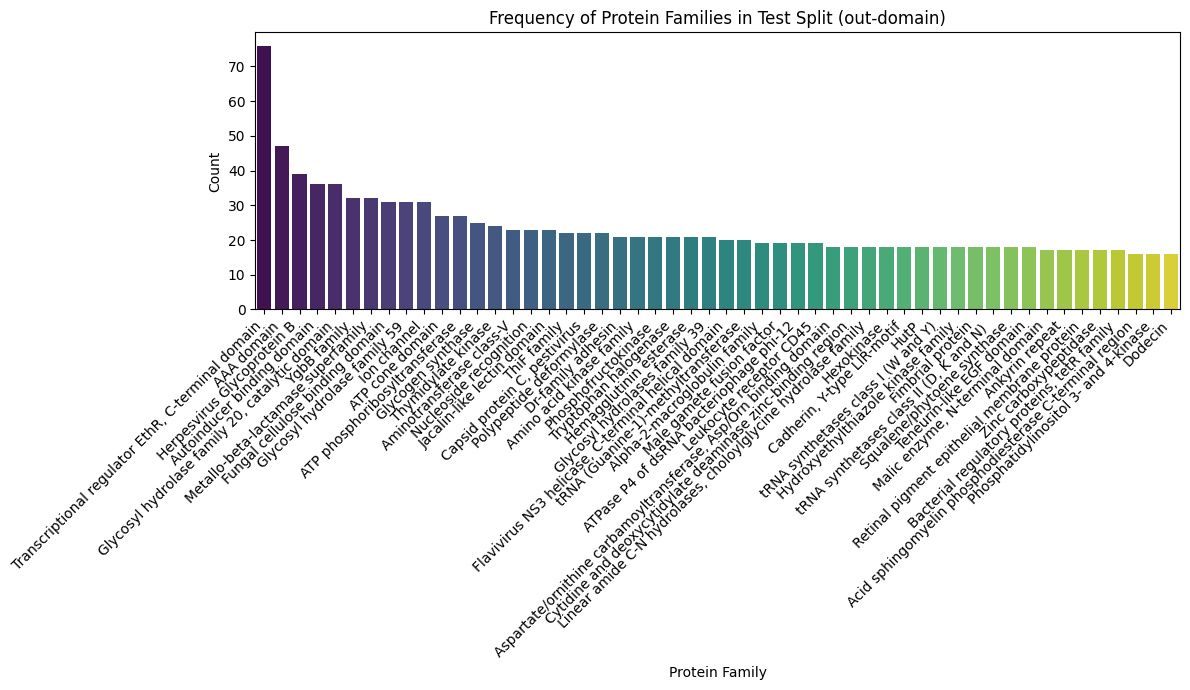

In [ ]:
pfamily_counts = filtered_subset_test['clan_name'].value_counts() # there are already only top 50 families in the df

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=pfamily_counts.index, y=pfamily_counts.values, palette="viridis")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.title("Frequency of Protein Families in Test Split (out-domain)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# I have been able to replicate the plot so, filtered_subset has the correct top 50 families.

In [ ]:
filtered_subset_test.to_csv('/content/drive/MyDrive/Binder_Generation/protein_pocket_analysis/Out-domain_top52_allpdbs.csv')